[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kamerlinlab/KIF/blob/main/tutorials/legacy_tutorials/Tutorial_PTP1B_Classification_ML_Stats.ipynb)

## Tutorial for Classification Machine Learning and Statistical Analysis on Simulations of PTP1B. 

In this jupyter notebook we will use the model_building.py and stat_modelling.py modules to identify differences in the molecular interactions across PTP1B when the WPD-loop of PTP1B is in the Closed state, versus when the WPD-loop is in the Open state.

This notebook will also cover all the pre- and post-processing steps requireds to prepare, analyse and visualise the results.

The dataset used here is for WT PTP1B and is the same data as what was used in the manuscript. 

<center><img src="https://raw.githubusercontent.com/kamerlinlab/KIF/main/tutorials/miscellaneous/ptp1b_banner.png" alt="Drawing" style="width: 70%" /></center>

### Setup

Install and load the required modules and then download the dataset we'll be working on from google drive

In [50]:
# Alongside installing KIF, we'll be using plotly to visualise some of the results. 
# We'll use kaleido with plotly.
%pip install KIF plotly 
%pip install -U kaleido 

Note: you may need to restart the kernel to use updated packages.



In [51]:
import pandas as pd

from key_interactions_finder import pycontact_processing
from key_interactions_finder import data_preperation
from key_interactions_finder import model_building
from key_interactions_finder import stat_modelling
from key_interactions_finder import post_proccessing
from key_interactions_finder import pymol_projections

We will first need to download the PTP1B dataset from google drive. 
The tutorial data will be saved in the relative path defined by "save_dir" in the cell block below.

You can change this as you see fit. If you want to use the current directory you can do:

save_dir=""

In [52]:
from key_interactions_finder.utils import download_prep_tutorial_dataset

drive_url = r"https://drive.google.com/file/d/1nbK3fw7z1hDXiGINZe-VT1SGdPbNhF07/view?usp=share_link"
save_dir = "tutorial_datasets"

download_prep_tutorial_dataset(drive_url=drive_url, save_dir=save_dir)

Downloading...
From: https://drive.google.com/uc?id=1nbK3fw7z1hDXiGINZe-VT1SGdPbNhF07
To: c:\Users\Rory Crean\Desktop\Github\key-interactions-finder\tutorials\tutorial_datasets\tutorial_dataset.zip
100%|██████████| 158M/158M [00:06<00:00, 24.4MB/s] 


Tutorial files were successfully downloaded and unzipped.


At this point, we'll define the location of our downloaded input files and where we would like to save our output files to throughout this tutorial.

In [53]:
# inputs
in_dir = save_dir + r"/PTP1B_data/example_horizontal_data"
classifications_file = save_dir + r"/PTP1B_data/example_horizontal_data/WT_PTP1B_Class_Assingments.txt"

# The pdb file will later be used to determine the distance of each residue to a site of interest.
pdb_file = save_dir + r"/PTP1B_data/WT_PTP1B_Phospho_Enzyme_Closed.pdb"


# output folders for the stats and ml analysis. These will be created if they don't already exist.
stats_out_dir = save_dir + r"/PTP1B_stat_analysis"
ml_out_dir = save_dir + r"/PTP1B_ml_analysis"

### Preperation Step 1. Process PyContact files with the pycontact_processing.py module 

In this section we will work with the PyContact output files generated. Here we will merge our seperate runs together and remove any false interactions that can be generated by the PyContact library. Note that these blocks are from the same frames but with different ranges of residues to search through. 

In [54]:
pycontact_files_horizontal = ["PyContact_Per_Frame_Interactions_Block1.csv", "PyContact_Per_Frame_Interactions_Block2.csv",
                              "PyContact_Per_Frame_Interactions_Block3.csv", "PyContact_Per_Frame_Interactions_Block4.csv",
                              "PyContact_Per_Frame_Interactions_Block5.csv", "PyContact_Per_Frame_Interactions_Block6.csv",
                              "PyContact_Per_Frame_Interactions_Block7.csv", "PyContact_Per_Frame_Interactions_Block8.csv",
                              "PyContact_Per_Frame_Interactions_Block9.csv", "PyContact_Per_Frame_Interactions_Block10.csv",
                              "PyContact_Per_Frame_Interactions_Block11.csv", "PyContact_Per_Frame_Interactions_Block12.csv",
                              "PyContact_Per_Frame_Interactions_Block13.csv", "PyContact_Per_Frame_Interactions_Block14.csv",
                              "PyContact_Per_Frame_Interactions_Block15.csv", "PyContact_Per_Frame_Interactions_Block16.csv",
                              "PyContact_Per_Frame_Interactions_Block17.csv", "PyContact_Per_Frame_Interactions_Block18.csv",
                              "PyContact_Per_Frame_Interactions_Block19.csv", "PyContact_Per_Frame_Interactions_Block20.csv",
                              ]

pycontact_dataset = pycontact_processing.PyContactInitializer(
    pycontact_files=pycontact_files_horizontal,
    multiple_files=True,
    merge_files_method="horizontal",  
    remove_false_interactions=True,
    in_dir=in_dir,
)

Your PyContact file(s) have been succefully processed.
You have 1886 features and 10000 observations.
The fully processed dataframe is accesible from the '.prepared_df' class attribute.


In [55]:
# As outputted above, we can inspect the newly prepared dataset by accessing the '.prepared_df' class attribute as follows:
pycontact_dataset.prepared_df

,1Glu 241Ser Hbond sc-bb,1Glu 240Pro Hbond sc-bb,1Glu 4Lys Hbond bb-sc,1Glu 5Glu Hbond bb-bb,1Glu 6Phe Other bb-bb,2Met 240Pro Hbond sc-bb,2Met 5Glu Hbond bb-bb,2Met 245Ile Hbond sc-sc,2Met 270Tyr Other bb-sc,2Met 6Phe Hbond bb-bb,...,287Gln 296Glu Other sc-sc,286Val 293Leu Hydrophobic sc-sc,292Glu 298Leu Other sc-sc,290Trp 296Glu Other bb-sc,291Lys 298Leu Hbond sc-bb,288Asp 297Asp Other bb-sc,294Ser 298Leu Other bb-sc,288Asp 298Leu Other sc-sc,287Gln 298Leu Other bb-sc,289Gln 298Leu Other bb-sc
0,2.79062,2.22760,11.75476,3.85765,0.01413,0.91267,4.97278,0.83832,2.71548,3.32993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.48888,0.15072,11.56569,2.01823,0.00000,1.89134,3.61045,0.08871,1.04626,3.49882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.65394,0.11149,7.74254,3.23310,0.00000,0.29681,4.05759,0.01007,1.47758,2.89084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.67279,0.26855,7.00332,1.61461,0.00000,3.11450,4.76641,0.15005,1.11730,2.75300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.73688,0.23481,5.10867,1.28357,0.00000,1.68206,3.98947,1.06603,2.91757,3.42521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5.88591,0.01018,9.95938,3.59306,0.00000,1.78412,5.69829,1.32305,1.11285,3.48554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,8.34367,0.01030,9.86854,2.94537,0.00000,0.16410,4.74343,2.71557,1.36727,3.43449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,9.10518,0.02668,6.73513,1.70116,0.00000,0.09681,3.34138,1.84982,0.99641,3.39886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,2.33875,0.00000,8.18129,2.79464,0.00000,0.64758,5.16315,2.49588,1.48416,3.21917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preperation Step 2. Prepare the Dataset for calculations with the data_preperation.py module. 

In this step, we take our dataframe and merge our per frame classifications file to it.

We can also optionally perform several forms of filtering on the PyContact features to select what types of interactions we would like to study.  

In [56]:
# First we generate an instance of the SupervisedFeatureData class (because we have per frame target labels).
supervised_dataset = data_preperation.SupervisedFeatureData(
    input_df=pycontact_dataset.prepared_df,
    target_file=classifications_file,
    is_classification=True,
    header_present=False # If your target_file has a header present, set to True.
)

Your PyContact features and target variable have been succesufully merged.
You can access this dataset through the class attribute: '.df_processed'.


In [57]:
# As stated above to access the newly generated dataframe we can use the class attribute as follows
supervised_dataset.df_processed

,Target,1Glu 241Ser Hbond sc-bb,1Glu 240Pro Hbond sc-bb,1Glu 4Lys Hbond bb-sc,1Glu 5Glu Hbond bb-bb,1Glu 6Phe Other bb-bb,2Met 240Pro Hbond sc-bb,2Met 5Glu Hbond bb-bb,2Met 245Ile Hbond sc-sc,2Met 270Tyr Other bb-sc,...,287Gln 296Glu Other sc-sc,286Val 293Leu Hydrophobic sc-sc,292Glu 298Leu Other sc-sc,290Trp 296Glu Other bb-sc,291Lys 298Leu Hbond sc-bb,288Asp 297Asp Other bb-sc,294Ser 298Leu Other bb-sc,288Asp 298Leu Other sc-sc,287Gln 298Leu Other bb-sc,289Gln 298Leu Other bb-sc
0,Closed,2.79062,2.22760,11.75476,3.85765,0.01413,0.91267,4.97278,0.83832,2.71548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Closed,1.48888,0.15072,11.56569,2.01823,0.00000,1.89134,3.61045,0.08871,1.04626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Closed,2.65394,0.11149,7.74254,3.23310,0.00000,0.29681,4.05759,0.01007,1.47758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Closed,0.67279,0.26855,7.00332,1.61461,0.00000,3.11450,4.76641,0.15005,1.11730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Closed,0.73688,0.23481,5.10867,1.28357,0.00000,1.68206,3.98947,1.06603,2.91757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Open,5.88591,0.01018,9.95938,3.59306,0.00000,1.78412,5.69829,1.32305,1.11285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,Open,8.34367,0.01030,9.86854,2.94537,0.00000,0.16410,4.74343,2.71557,1.36727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,Open,9.10518,0.02668,6.73513,1.70116,0.00000,0.09681,3.34138,1.84982,0.99641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,Open,2.33875,0.00000,8.18129,2.79464,0.00000,0.64758,5.16315,2.49588,1.48416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Optional Feature Filtering

In the above dataframe we have 1887 columns (so 1886 features + 1 target). We can take all of these forward for the stastical analysis or we can perform some filtering in advance (the choice is yours). 
There are five built in filtering methods available to you to perform filtering:

1. **filter_by_occupancy(min_occupancy)** - Remove features that have an %occupancy less than the provided cut-off. %Occupancy is the % of frames with a non 0 value, i.e. the interaction is present in that frame.

2. **filter_by_interaction_type(interaction_types_included)** - PyContact defines four types of interactions ("Hbond", "Saltbr", "Hydrophobic", "Other"). You select the interactions your want to include.

3. **filter_by_main_or_side_chain(main_side_chain_types_included)** - PyContact can also define if each interaction is primarily from the backbone or side-chain for each residue. You select the interaction combinations you want to include. Options are: "bb-bb", "sc-sc", "bb-sc", "sc-bb". Where bb = backbone and sc = sidechain.

4. **filter_by_avg_strength(average_strength_cut_off)** - PyContact calculates a per frame contact score/strength for each interaction. You can filter features by the average score. Values below the cut-off are removed. 

5. **filter_by_occupancy_by_class(min_occupancy)** - Special alternative to the the standard filter features by occupancy method. %occupancy is determined for each class (as opposed to whole dataset), meaning only observations from 1 class have to meet the cut-off to keep the feature. Only avaible to datasets with a categorical target variable (classification). 


Finally if at any point in time you want to reset any filtering you've already performed, you can use the following method: 

6. **reset_filtering()** 


In [58]:
# An example of filtering the dataset using the available methods. 
supervised_dataset.reset_filtering() 
print(f"Number of features before any filtering: {len(supervised_dataset.df_processed.columns) - 1}")

# Features with a %occupancy of less than 25% are removed. 
supervised_dataset.filter_by_occupancy_by_class(min_occupancy=25)
print(f"Number of features after filtering by occupancy: {len(supervised_dataset.df_filtered.columns) - 1}")

# Remove features with interaction type "Other". 
supervised_dataset.filter_by_interaction_type(
    interaction_types_included=["Hbond", "Saltbr", "Hydrophobic"]) 
print(f"Number of features after filtering by interaction type: {len(supervised_dataset.df_filtered.columns) - 1}")

# No filtering performed here as all possible combinations are included. 
supervised_dataset.filter_by_main_or_side_chain(
    main_side_chain_types_included=["bb-bb", "sc-sc", "bb-sc", "sc-bb"]  
)
print(f"Number of features after NOT filtering by main or side chain: {len(supervised_dataset.df_filtered.columns) - 1}")

# Features with an average interaction strength less than 0.5 will be removed. 
supervised_dataset.filter_by_avg_strength(
    average_strength_cut_off=0.5,  
)
print(f"Number of features after filtering by average interaction scores: {len(supervised_dataset.df_filtered.columns) - 1}")

Number of features before any filtering: 1886
Number of features after filtering by occupancy: 1156
Number of features after filtering by interaction type: 696
Number of features after NOT filtering by main or side chain: 696
Number of features after filtering by average interaction scores: 615


Now if we look at the class attributes of our SupervisedFeatureData() instance (we called it: supervised_dataset) using the special "\_\_dict__" method we can see two dataframes we could use in the stastical analysis to follow. 

In [59]:
supervised_dataset.__dict__.keys()

dict_keys(['input_df', 'is_classification', 'target_file', 'header_present', 'df_processed', 'df_filtered'])

They are: 
- 'df_processed' - The unfiltered dataframe, 1886 features
- 'df_filtered' - The filtered dataframe. Less than 1886 features. 

In the following sections we will use the filtered dataframe but either dataframe could be justified based on your goals. 

## Analysis Time! 

Our dataset is now ready for either statistical analysis or ML or both! 

### Part 1.1. Perform Statistical Analysis with the stat_modelling.py module. 

Now we will perform the actual statistical modelling to compare the differences for each feature when the WPD-loop is in the closed and open state. 

With this module, we can calculate two different metrics to evaluate how different/similar each feature is when the protein is in the closed WPD-loop conformation or the open-WPD-loop conformation: 

1. The [Jensen-Shannon distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jensenshannon.html). For this method, Kernel density estimations (KDEs) are calculated for the normalised interaction stength of feature in each state before performing the calculation. We can also extract these KDEs as we did in the manuscript (and will show you how to do it here) to compare the interaction strengths for each state. 

2. The [mutual information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) using the implementation available in Scikit-learn. The mutual information can capture any kind of dependancy/relationship between variables and score their dependancy

In both cases, the higher the score, the more "different" the feature is when in the two different states. Scores are in the range 0 and 1.   

In [60]:
stat_model = stat_modelling.ClassificationStatModel(
    dataset=supervised_dataset.df_filtered, 
    class_names=["Closed", "Open"], # select the two class labels to compare. Has to be 2 labels. 
    out_dir=stats_out_dir,
    interaction_types_included=["Hbond", "Saltbr", "Hydrophobic"] # select which interaction types to include, in this case: "Other" removed. 
)

In [61]:
# First we can calculate the Jensen-Shannon distances
stat_model.calc_js_distances()

Jensen-Shannon (JS) distances calculated.
tutorial_datasets\PTP1B_stat_analysis\Jensen_Shannon_Per_Feature_Scores.csv written to disk.
You can also access these results via the class attribute: 'js_distances'.


In [62]:
# Now we can calculate the mutual information
stat_model.calc_mutual_info_to_target()

Mutual information scores calculated.
tutorial_datasets\PTP1B_stat_analysis\Mutual_Information_Per_Feature_Scores.csv written to disk.
You can also access these results via the class attribute: 'mutual_infos'.


In [63]:
# As printed above we can access the results from these calculations from the class instance's (we called it stat_model) attributes. 
mi_results = stat_model.mutual_infos
js_results = stat_model.js_distances
# stat_model.__dict__.keys() # uncomment to see all attributes available. 

### Part 1.2. Work up the Statistical Analysis with the post_proccessing.py module. 

In this module we have access to 3 methods to process the results. 

1. We can convert the per feature scores to per residue scores, by summing (and then normalising) every per feature score that each residue is involved in.
This can allow us to identify residues which seem to differ the most between each state. 

2. We can also try to predict the "direction" that each feature favours. This essentially means in which class is the feature on average stronger in.  

3. We can obtain the kernel density estimations for selected interactions to compare how the interactions stengths differ between states. 

In [64]:
# First generate an instance of the class. 
post_proc = post_proccessing.StatClassificationPostProcessor(
    stat_model=stat_model,
    out_dir=stats_out_dir
)

# As you have already seen in the prior steps, we can take a look at class attributes with the __dict__ method. 
# Note that some of these attributes will be empty until we have run the next few code blocks.
post_proc.__dict__.keys()

dict_keys(['stat_model', 'out_dir', 'per_residue_mutual_infos', 'per_residue_js_distances', 'feature_directions'])

In [65]:
# Now we can run the get_per_res_scores() method, changing the stat_method accordingly.
js_per_res_scores = post_proc.get_per_res_scores(
    stat_method="jensen_shannon")
mi_per_res_scores = post_proc.get_per_res_scores(
    stat_method="mutual_information")

tutorial_datasets\PTP1B_stat_analysis\Jensen_Shannon_Distance_Scores_Per_Residue.csv written to disk.
tutorial_datasets\PTP1B_stat_analysis\Mutual_Information_Scores_Per_Residue.csv written to disk.


In [66]:
# Here we predict the "direction" that each feature favours. 
# This essentially means in which class is the feature on average stronger in.  
# Because of the nature of the method, a warning is given. 
post_proc.estimate_feature_directions()

tutorial_datasets\PTP1B_stat_analysis\Feature_Direction_Estimates.csv written to disk.
You can access these predictions through the 'feature_directions' class attribute.


c:\users\rory crean\desktop\github\key-interactions-finder\key_interactions_finder\post_proccessing.py:748: UserWarning:

Warning, this method is very simplistic and just calculates the average contact score/strength for all features for both classes to determine the direction each feature appears to favour. You should therefore interpret these results with care...

c:\users\rory crean\desktop\github\key-interactions-finder\key_interactions_finder\post_proccessing.py:758: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [67]:
# We can also extract the kernel density estimations for the feature with the largest differences. 
x_values, selected_kdes = post_proc.get_kdes(
    number_features=10) # top 10 features based on Jensen Shannon Distances. 

selected_kdes["Closed"].keys() # here we can see what features were in the top 10 and could be plotted. 

dict_keys(['180Asp 220Arg Hbond bb-sc', '182Gly 265Gln Hbond bb-sc', '179Pro 220Arg Hbond bb-sc', '181Phe 262Thr Hbond bb-sc', '181Phe 265Gln Hbond bb-sc', '186Ser 190Phe Hbond bb-bb', '181Phe 261Gln Hbond sc-sc', '186Ser 189Ser Hbond bb-bb', '111Arg 180Asp Saltbr sc-sc', '178Trp 182Gly Hbond sc-bb'])

**Optional:** Now we will take a look at the most different feature in both states using the plotly plotting library. 

In [68]:
import plotly.express as px
import plotly.graph_objects as go

In [69]:
interaction_df = pd.DataFrame(
    {"Normalised Interaction Strength": list(x_values[:, 0]),
     "Closed WPD-Loop": selected_kdes["Closed"]["180Asp 220Arg Hbond bb-sc"],
     "Open WPD-Loop": selected_kdes["Open"]["180Asp 220Arg Hbond bb-sc"]
    }
)

interaction_df.head()

,Normalised Interaction Strength,Closed WPD-Loop,Open WPD-Loop
0,0.00,0.000393,19.911096
1,0.02,0.002548,12.135692
2,0.04,0.008382,2.741695
3,0.06,0.019591,0.237508
4,0.08,0.037140,0.012023


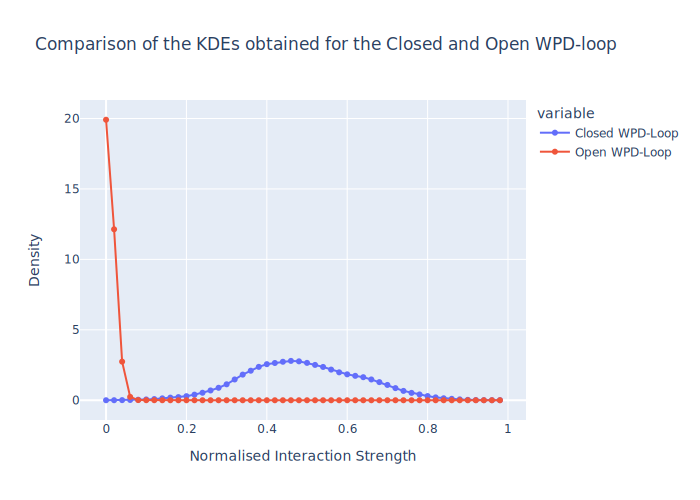

In [70]:
fig = px.line(interaction_df, x="Normalised Interaction Strength", y=["Closed WPD-Loop", "Open WPD-Loop"], 
    markers=True, title="Comparison of the KDEs obtained for the Closed and Open WPD-loop"
)
fig.update_layout(yaxis_title="Density")
fig.show("svg") # to make this plot interactive, remove "svg" and run the cell block. 

Looking at the above graph it is clear that interaction above is only present in the closed WPD-loop conformation 

**Optional:** Now we will user a helper function within the utils.py module to determine the heavy atom distance of each residue to the site of interest (in this case the WPD-loop). You can use any form of mdtraj selection command (both single and multi-atom) to define the site of interest to you. In this case, we will use the heavy atoms of residue 180 (D181 in the PDB - a catalytic residue on the WPD-loop) as the site of interest. 

In [71]:
from key_interactions_finder import utils 

out_file = stats_out_dir + "Distance_toCalpha_D181_Closed.txt"
distances_to_site = utils.per_residue_distance_to_site(
    pdb_file=pdb_file,
    site_defintion="not name H* and resid 180",
    first_residue=1,
    last_residue=298,
    side_chain_only=False, # only consider side chain atoms of each residue (uses CA for glycine)
    out_file=out_file,
)

c:\anaconda3\envs\ML_conf_features_3.8\lib\site-packages\MDAnalysis\topology\PDBParser.py:328: UserWarning:

Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.



tutorial_datasets/PTP1B_stat_analysisDistance_toCalpha_D181_Closed.txt written to disk.


With this, we can plot the relative per residue scores against the distance from the binding site. 

One such way to do this is with a "Bubble plot", with the size of the bubble used to represent the per residue score.

In [72]:
# Convert the dataset to be easy to use with plotly. 
df_scores = pd.DataFrame.from_dict([js_per_res_scores]).T
df_dists = pd.DataFrame.from_dict([distances_to_site]).T

df_score_dist = pd.merge(df_scores, df_dists, left_index=True, right_index=True)
df_score_dist.columns = ["Per Residue Score", "Distance to D181 (Å)"]
df_score_dist.head(5)

,Per Residue Score,Distance to D181 (Å)
178,1.00000,3.68
220,0.87997,3.38
180,0.83349,0.00
190,0.74260,12.86
265,0.66394,5.35


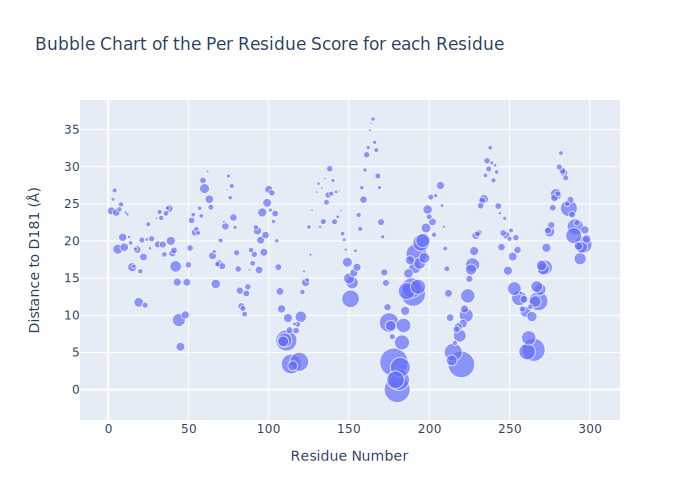

In [73]:
fig = px.scatter(df_score_dist, x=df_score_dist.index, y="Distance to D181 (Å)",
                size="Per Residue Score", size_max=20,
				title="Bubble Chart of the Per Residue Score for each Residue",
				labels={"index": "Residue Number"}
)

fig.show("svg") # to make this plot interactive, remove "svg" and run the cell block. 

Unsurpsingly Some of the most of the highest scoring residues have a low distance to D181, however we are still able to identify residues further away with reasonably high scores, such as those with residue numbers in the 280-290 region.

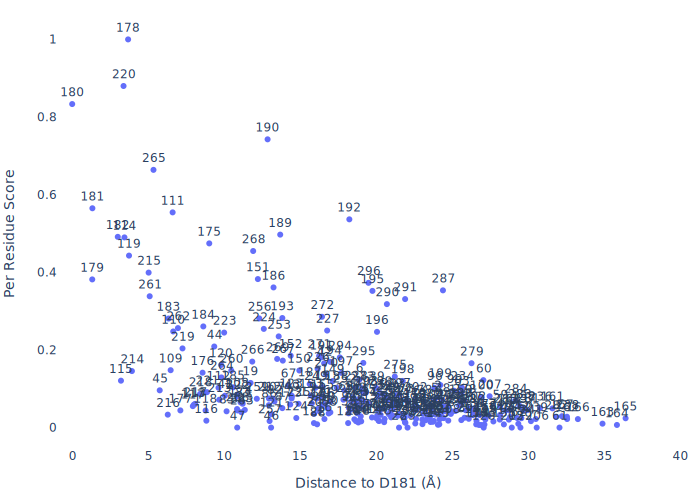

In [74]:
layout = dict(plot_bgcolor="white",
              margin=dict(t=20, l=20, r=20, b=20),
              xaxis=dict(title="Distance to D181 (Å)", range=[-1, 40]),
              yaxis=dict(title="Per Residue Score", range=[-0.05, 1.05],))

data = go.Scatter(x=df_score_dist["Distance to D181 (Å)"],
                  y=df_score_dist["Per Residue Score"],
                  text=df_score_dist.index,
                  textposition="top center", mode="markers+text",
)

fig = go.Figure(data=data, layout=layout) 

fig.show("svg") # to make this plot interactive, remove "svg" and run the cell block. 

Another way to visualise the data, of course this would need to be made a lot prettier (for a start by not labelling all residues).

### Part 1.3. Project the Results onto Protein Structures with the pymol_projections.py module. 
 
Naturally, we may want to visualise some of the results we have generated above onto a protein structure. We can take advantage of
the functions provided in the pymol_projections.py module to do this. 

As the name suggests this will output [PyMOL](https://pymol.org/) compatible python scripts which can be run to represent the results
at the: 

1. Per feature level. (Cylinders are drawn between each feature, with the cylinder radii marking how strong the relative difference is. 
2. Per residue level. The Carbon alpha of each residue will be depicted as a sphere, with the sphere radii depicting how strong the the relative difference is. 

In [75]:
# Write PyMOL compatable scripts for the per feature results.
# Simply swap between the two statistical methods as shown below. 
pymol_projections.project_pymol_top_features(
    per_feature_scores=stat_model.js_distances,
    model_name="jensen_shannon",
    numb_features=125, # can be any integer values or "all" if you would like all features returned.
    out_dir=stats_out_dir
)

pymol_projections.project_pymol_top_features(
    per_feature_scores=stat_model.mutual_infos,
    model_name="mutual_information",
    numb_features=125, # can be any integer values or "all" if you would like all features returned.
    out_dir=stats_out_dir
)

The file: tutorial_datasets\PTP1B_stat_analysis\jensen_shannon_Pymol_Per_Feature_Scores.py was written to disk.
The file: tutorial_datasets\PTP1B_stat_analysis\mutual_information_Pymol_Per_Feature_Scores.py was written to disk.


In [76]:
# Write PyMOL compatable scripts for the per residue results.
# Simply swap between the two statistical methods as shown below. 
pymol_projections.project_pymol_per_res_scores(
    per_res_scores=js_per_res_scores,
    model_name="jensen_shannon",
    out_dir=stats_out_dir
)

pymol_projections.project_pymol_per_res_scores(
    per_res_scores=mi_per_res_scores,
    model_name="mutual_information",
    out_dir=stats_out_dir
)

The file: tutorial_datasets\PTP1B_stat_analysis\jensen_shannon_Pymol_Per_Res_Scores.py was written to disk.
The file: tutorial_datasets\PTP1B_stat_analysis\mutual_information_Pymol_Per_Res_Scores.py was written to disk.


Heres an example of the figures you can make , see the manuscript for more examples and what the figures represent.

<center><img src="https://raw.githubusercontent.com/kamerlinlab/KIF/main/tutorials/miscellaneous/ptp1b_example_outputs.png" alt="Drawing" style="width: 70%" /></center>

### Part 2.1 Perform Machine Learning (ML) with the model_building.py module. 

Now we will use ML to generate models that can describe the difference between the WPD-loop closed and open states. 

With this module, we use the per feature scores from each ML model to to evaluate how different/similar each feature is when the protein is in the closed WPD-loop conformation or the open-WPD-loop conformation.

**We will use three ensemble based classification models:**

1. [Categorical Boosting](https://catboost.ai/) - (Refered to as: CatBoost)

2. [Extreme Gradient Boosting](https://xgboost.readthedocs.io/en/stable/) - (Refered to as: XGBoost)

3. [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  (Refered to as: Random_Forest)

In all cases, the higher the score, the more "different" the feature is when in the two different states.

In [77]:
# First we will remove all feature involving the WPD-loop, otherwise the model building will be too easy.
# This was discussed in detail in the preprint, but the basic idea is that if the WPD-loop interactions are 
# included then only one of two of these interactions would be enough to predict the conformational state of 
# the WPD-loop which is non-ideal for our goals. 

df = supervised_dataset.df_filtered
# filter to remove those residues on the WPD-loop (residues 176-189)
df_no_WPD_loop = df.loc[:, df.columns.str.contains('176|177|178|179|180|181|182|183|184|185|186|187|188|189')==False]
df_no_WPD_loop.head(3)

# We will now use "df_no_WPD_loop" in the following cell as the dataset instead of "supervised_dataset.df_filtered"

,Target,9Ile 18Ile Hydrophobic sc-sc,9Ile 15Trp Hydrophobic sc-sc,9Ile 14Ser Hbond bb-bb,9Ile 13Gly Hbond bb-bb,9Ile 12Ser Hbond bb-bb,99Trp 168Arg Hbond sc-sc,99Trp 166Glu Hbond sc-sc,99Trp 161Asn Hbond sc-sc,99Trp 159Leu Hydrophobic sc-sc,...,104Arg 207Hip Hbond sc-sc,104Arg 202Ser Hbond sc-sc,104Arg 171Leu Hbond bb-sc,104Arg 170Ile Hbond bb-bb,104Arg 169Glu Saltbr sc-sc,103Ser 209Pro Hbond sc-bb,103Ser 208Gly Hbond bb-bb,102Lys 208Gly Hbond bb-bb,102Lys 207Hip Hbond bb-bb,102Lys 168Arg Hbond sc-sc
0,Closed,2.74270,12.20452,9.05994,3.04996,7.32765,15.63908,4.15315,4.98321,2.65085,...,2.35995,0.63756,4.65116,3.12166,6.64776,4.48079,1.02525,3.03137,0.04986,1.05851
1,Closed,2.48664,12.80458,7.53956,3.45816,6.19969,27.22723,4.62006,7.64728,1.49619,...,4.29638,2.08714,8.12584,2.28895,6.82945,3.18406,0.28608,2.80741,3.25076,1.45839
2,Closed,1.98872,10.17568,3.67532,2.43468,6.19670,26.31065,5.25182,4.73549,2.45713,...,3.25030,0.08796,7.60715,5.41314,10.93755,2.52011,1.36476,3.10390,0.75912,5.53424


In [78]:
# Instantiate the ClassificationModel class. 
# Clearly there are many parameters here, using your IDE you can hover over ClassificationModel to see what each parameter does
ml_model = model_building.ClassificationModel(
    dataset=df_no_WPD_loop, # if want all residues included can replace this with: "supervised_dataset.df_filtered"
    evaluation_split_ratio=0.15,
    classes_to_use=["Closed", "Open"], 
    models_to_use=["CatBoost", "XGBoost", "Random_Forest"],
    scaling_method="min_max",
    out_dir=ml_out_dir, 
    cross_validation_splits=5, 
    cross_validation_repeats=3,
    search_approach="none",
)


Below is a summary of the machine learning you have planned.
You will use 5-fold cross validation and perform 3 repeats.
You will use up to 572 features to build each model, with 85.0% of your data used for training the model, which is 8204 observations. 
15.0% of your data will be used for evaluating the best models produced by the 5-fold cross validation, which is 1448 observations.
You have selected to build 3 machine learning model(s), with the following hyperparameters: 
 
A CatBoost model, with grid search parameters: 
{'iterations': [100]} 

A XGBoost model, with grid search parameters: 
{'n_estimators': [100]} 

A Random_Forest model, with grid search parameters: 
{'n_estimators': [100], 'max_depth': [100]} 

If you're happy with the above, lets get model building!


Now we can go ahead and build the models.

We have one optional parameter in the command below which is to save the models generated. This can be useful if you ever want to come back and do the post-processing later.

If you set this to true all the files required will be saved to a folder called "temporary_files" in your current working directory. 

With the current setup this calculation will not take long (maybe 5-10 mins to run on a standard laptop). However, you could perform a very exhausitve calculation using grid search CV (possible by changing the "search_approach" parameter in model_building.ClassificationModel() ), in which case it might be useful

In [79]:
ml_model.build_models(save_models=True)

Model saved to disk at: temporary_files\CatBoost_Model.pickle
Model saved to disk at: temporary_files\XGBoost_Model.pickle
Model saved to disk at: temporary_files\Random_Forest_Model.pickle
Model building complete, returning final results with train/test datasets to you.


,model,best_params,best_score,best_standard_deviation,Time taken to build model (minutes)
0,CatBoost,{'iterations': 100},0.984885,0.002878,2.02
1,XGBoost,{'n_estimators': 100},0.983017,0.002857,2.65
2,Random_Forest,"{'max_depth': 100, 'n_estimators': 100}",0.971559,0.003654,2.78


With the models now built, we can see the models seem to be quite equally matched in terms of accuracy for the train and test sets. 
We can now evaluate the quality of the models on the validation dataset (also sometimes refered to as the hold-out set).

For each ML model built, a pandas dataframe can be generated with metrics describing the accuracy of the model on the validation dataset. 
If you are unfamiliar with any of the terms presented below, [feel free to check out this guide from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [80]:
reports = ml_model.evaluate_models()

Returning classification reports for each model inside a single dictionary


In [81]:
reports["XGBoost"]

,precision,recall,f1-score,support
Closed,0.975643,0.991747,0.983629,727.0
Open,0.991537,0.975035,0.983217,721.0
accuracy,N/A,N/A,0.983425,1448
macro avg,0.98359,0.983391,0.983423,1448.0
weighted avg,0.983557,0.983425,0.983424,1448.0


In [82]:
reports["CatBoost"]

,precision,recall,f1-score,support
Closed,0.973009,0.991747,0.982289,727.0
Open,0.991513,0.972261,0.981793,721.0
accuracy,N/A,N/A,0.982044,1448
macro avg,0.982261,0.982004,0.982041,1448.0
weighted avg,0.982223,0.982044,0.982042,1448.0


In [83]:
reports["Random_Forest"]

,precision,recall,f1-score,support
Closed,0.965007,0.986245,0.97551,727.0
Open,0.985816,0.963939,0.974755,721.0
accuracy,N/A,N/A,0.975138,1448
macro avg,0.975411,0.975092,0.975132,1448.0
weighted avg,0.975368,0.975138,0.975134,1448.0


Another popular way to evaluate model quality is to generate confusion matrices. 

Using the command below we can generate confusion matrices (stored as numpy arrays) for each model we generated. 

You can then easily plot these confusion matrices in whatever graphing program you like. In this case, I will use plotly as before, but you could easily use another graphing package.

In [84]:
confusion_matrices = ml_model.generate_confusion_matrix()

In [85]:
confusion_matrices["XGBoost"]

array([[721,   6],
       [ 18, 703]], dtype=int64)

Again, you'll need plotly installed (see above) if you want to make this figure.

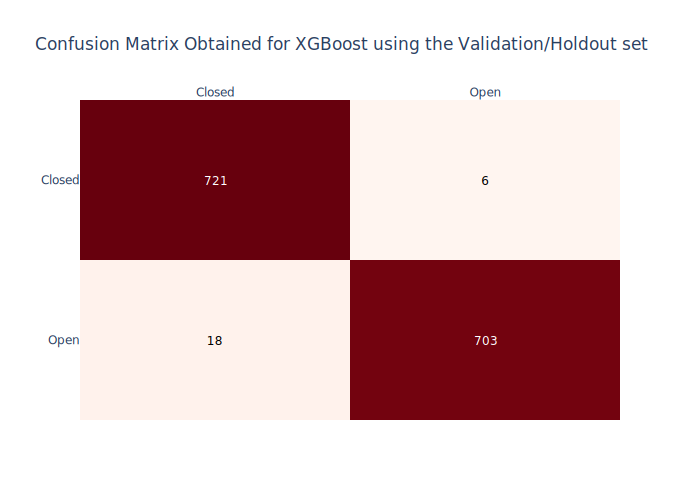

In [86]:
import plotly.figure_factory as ff

labels = ["Closed", "Open"]
fig = ff.create_annotated_heatmap(confusion_matrices["XGBoost"], x = labels, y = labels, colorscale="reds")
fig.update_layout(yaxis = dict(categoryorder = "category descending"))
fig.update_layout(title="Confusion Matrix Obtained for XGBoost using the Validation/Holdout set")
fig.show("svg") # to make this plot interactive, remove "svg" and run the cell block. 

## Part 2.2. Work up the ML results with the post_proccessing.py module. 

In order to perform the analysis we will need to provide the models generated in Part 2.1 Shown below are the two possible ways to do this. 

In [87]:
# First we will make an instance of the SupervisedPostProcessor class.
ml_post_proc = post_proccessing.SupervisedPostProcessor(
    out_dir=ml_out_dir,
)

# Option 1 - Load models from the instance of the SupervisedModel class. 
ml_post_proc.load_models_from_instance(supervised_model=ml_model)

# Option 2 - Load models from disk. (If you've run the model building, shut down the kernel and now want to post-process).
#post_proc.load_models_from_disk(models_to_use=["XGBoost", "CatBoost", "Random_Forest"]) 

In [88]:
# After preparing the class we can now determine the per feature scores for each model made.
ml_post_proc.get_per_feature_scores()

tutorial_datasets\PTP1B_ml_analysis\CatBoost_Feature_Scores.csv written to disk.
tutorial_datasets\PTP1B_ml_analysis\XGBoost_Feature_Scores.csv written to disk.
tutorial_datasets\PTP1B_ml_analysis\Random_Forest_Feature_Scores.csv written to disk.
All per feature scores have now been saved to disk.


In [89]:
# We can also project these per feature scores onto the per-residue level. 
ml_post_proc.get_per_res_scores()

tutorial_datasets\PTP1B_ml_analysis\CatBoost_Per_Residue_Scores.csv written to disk.
tutorial_datasets\PTP1B_ml_analysis\XGBoost_Per_Residue_Scores.csv written to disk.
tutorial_datasets\PTP1B_ml_analysis\Random_Forest_Per_Residue_Scores.csv written to disk.
All per residue scores have now been saved to disk.


In [90]:
print(ml_post_proc.__dict__.keys())

dict_keys(['out_dir', 'feat_names', 'best_models', 'all_per_feature_scores', 'all_per_residue_scores'])


If we take a look at the class attributes we can see the per feature and per residue scores were not just saved to disk, but are also stored inside the class.

This means you could easily analyse them within Python if you want. I will show one more way to generate a quick figure here. Bear in mind these results can also be analysed in very similar ways to those generated in the statistical analysis section.

In [91]:
all_per_res_scores = ml_post_proc.all_per_residue_scores
all_per_feature_scores = ml_post_proc.all_per_feature_scores

In [92]:
import pandas as pd 
import plotly.express as px
df_all_per_res_scores = pd.DataFrame(all_per_res_scores).reset_index()
df_all_per_res_scores = df_all_per_res_scores.rename(columns={"index": "Residue Number"})
df_all_per_res_scores = df_all_per_res_scores.sort_values(["Residue Number"], ascending=True)
df_all_per_res_scores.head() 

,Residue Number,CatBoost,XGBoost,Random_Forest
165,2,0.00102,0.00122,0.01733
208,3,0.00000,0.00406,0.00543
209,4,0.00000,0.01491,0.00929
163,5,0.00106,0.01040,0.01592
107,6,0.00504,0.01313,0.02248


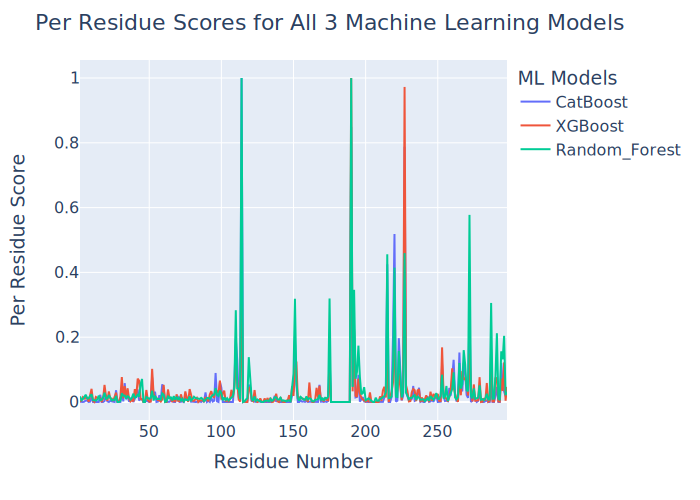

In [93]:
fig = px.line(df_all_per_res_scores, x="Residue Number", y=["CatBoost", "XGBoost", "Random_Forest"])
fig.update_layout(
    title="Per Residue Scores for All 3 Machine Learning Models",
    xaxis_title="Residue Number",
    yaxis_title="Per Residue Score",
    legend_title="ML Models",
    font=dict(size=16)
)

fig.show("svg") # remove "svg" to make the graph interactive 

### Part 2.3. Project the Results onto Protein Structures with the pymol_projections.py module. 
 
This section is essentially identical to 1.3, only that now we will output the ml results instead of the stats results

In [94]:
# Here you do not need to specify what model you would like to the output results for, all will be outputted simultaneously.
pymol_projections.project_multiple_per_res_scores(
    all_per_res_scores=ml_post_proc.all_per_residue_scores,
    out_dir=ml_out_dir
)

pymol_projections.project_multiple_per_feature_scores(
    all_per_feature_scores=ml_post_proc.all_per_feature_scores,
    numb_features="all",
    out_dir=ml_out_dir
)

The file: tutorial_datasets\PTP1B_ml_analysis\CatBoost_Pymol_Per_Res_Scores.py was written to disk.
The file: tutorial_datasets\PTP1B_ml_analysis\XGBoost_Pymol_Per_Res_Scores.py was written to disk.
The file: tutorial_datasets\PTP1B_ml_analysis\Random_Forest_Pymol_Per_Res_Scores.py was written to disk.
The file: tutorial_datasets\PTP1B_ml_analysis\CatBoost_Pymol_Per_Feature_Scores.py was written to disk.
The file: tutorial_datasets\PTP1B_ml_analysis\XGBoost_Pymol_Per_Feature_Scores.py was written to disk.
The file: tutorial_datasets\PTP1B_ml_analysis\Random_Forest_Pymol_Per_Feature_Scores.py was written to disk.
